In [ ]:
#!pip install install dowhy

In [ ]:
#!pip install numexpr==2.8.4

In [ ]:
#!pip install bottleneck==1.3.6

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import os
import seaborn as sns
# Set default Seaborn style
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = (20, 10)
import warnings
warnings.filterwarnings('ignore')
from dowhy import gcm, CausalModel
from dowhy.utils import plot, bar_plot
from scipy.stats import truncexpon, halfnorm


/var/folders/jn/zl4rcc1s56s5p6fm169l94mc0000gn/T/ipykernel_55522/1292991075.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Notes
- We have metrics for all of these nodes
- Not sure about the impact for mixing CPU starvation in percentage with latency metrics in this model
- https://access.redhat.com/articles/6271341
- https://access.redhat.com/solutions/4770281
- https://access.redhat.com/solutions/4885641



In [2]:
causal_graph_actual = nx.DiGraph([('CPUStarvation', 'etcdResponseTime'),
                           ('etcdNetworkPeer', 'etcdResponseTime'),
                           ('etcdBackendCommitDur', 'etcdResponseTime'),
                           ('etcdWallSyncDur', 'etcdResponseTime'),
                           ('etcdResponseTime', 'APIServerCache'),
                           ('etcdResponseTime', 'APIServerResponseTime'),
                           ('APIServerCache', 'APIServerResponseTime')
                          ])

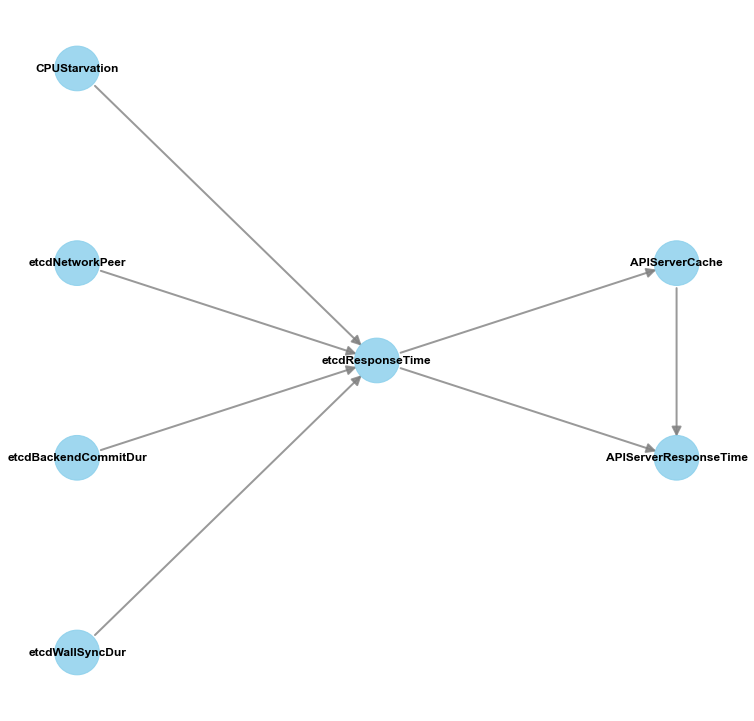

In [3]:
plot(causal_graph_actual, figure_size=[13, 13])

- Here, we are interested in the causal relationships between latencies of services rather than the order of calling the services.

- Do we have any metric about cache response time of API Server? I really hope so because that is a key component in this causal flow. But since I am not aware, I remove it from the `used` graph.

In [4]:
causal_graph_used = nx.DiGraph([('CPUStarvation', 'etcdResponseTime'),
                           ('etcdNetworkPeer', 'etcdResponseTime'),
                           ('etcdBackendCommitDur', 'etcdResponseTime'),
                           ('etcdWallSyncDur', 'etcdResponseTime'),
                           ('etcdResponseTime', 'APIServerResponseTime')
                          ])

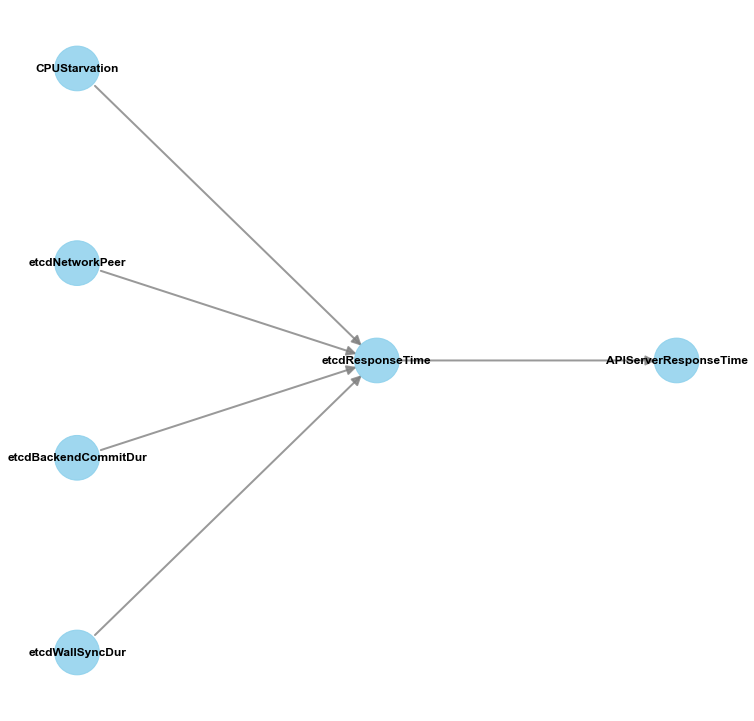

In [5]:
plot(causal_graph_used, figure_size=[13, 13])

In [6]:
def load_file(name) :
    
    fname = os.path.join(name)
    master_df = pd.read_csv(fname,index_col=0)
    return master_df

# This renders histogram in 3 columns per row.
# Fixed format
def examine_skewness_using_histogram(df,colnames):
    #number of rows of display
    #given column =3
    #depends on lenght of colnames
    rowcount=math.ceil(len(colnames)/3)
    
    # Visualizing skewness using histograms and density plots
    fig, axes = plt.subplots(nrows=rowcount, ncols=3, figsize=(10, 7))
    
    i=1
    for x in colnames :
        rowposition = (math.ceil(i/3)) -1
        colposition = i - (rowposition)*3 -1
        sns.histplot(df[x], kde=False, ax=axes[rowposition,colposition])
        axes[rowposition,colposition].set_title(x)    
        i += 1   
    
    plt.tight_layout()
    plt.show()

In [9]:
stable_df = load_file("stable_data.csv")
stable_df

,CPUStarvation,etcdNetworkPeer,etcdBackendCommitDur,etcdWallSyncDur,etcdResponseTime,APIServerResponseTime
0,0.047357,0.050741,0.078737,0.112054,1.003838,1.075278
1,0.092941,0.014481,0.104044,0.070172,0.895936,1.191295
2,0.033781,0.103193,0.007164,0.092829,0.754862,0.837878
3,0.055634,0.592269,0.351564,0.034298,1.695344,1.978330
4,0.452419,0.160847,0.268535,0.089815,1.484833,1.607748
...,...,...,...,...,...,...
9995,0.025654,0.051264,0.388748,0.190776,1.654952,1.655049
9996,0.156757,0.125569,0.065625,0.005615,0.885599,1.071720
9997,0.321404,0.131067,0.371347,0.171475,1.652595,1.822725
9998,0.007330,0.014126,0.238213,0.065733,0.887084,0.960471


#### Let us draw the treatment and the outcome (or effect) and other metrics in good stable data

array([[<AxesSubplot:title={'center':'CPUStarvation'}>,
        <AxesSubplot:title={'center':'etcdNetworkPeer'}>,
        <AxesSubplot:title={'center':'etcdBackendCommitDur'}>],
       [<AxesSubplot:title={'center':'etcdWallSyncDur'}>,
        <AxesSubplot:title={'center':'etcdResponseTime'}>,
        <AxesSubplot:title={'center':'APIServerResponseTime'}>]],
      dtype=object)

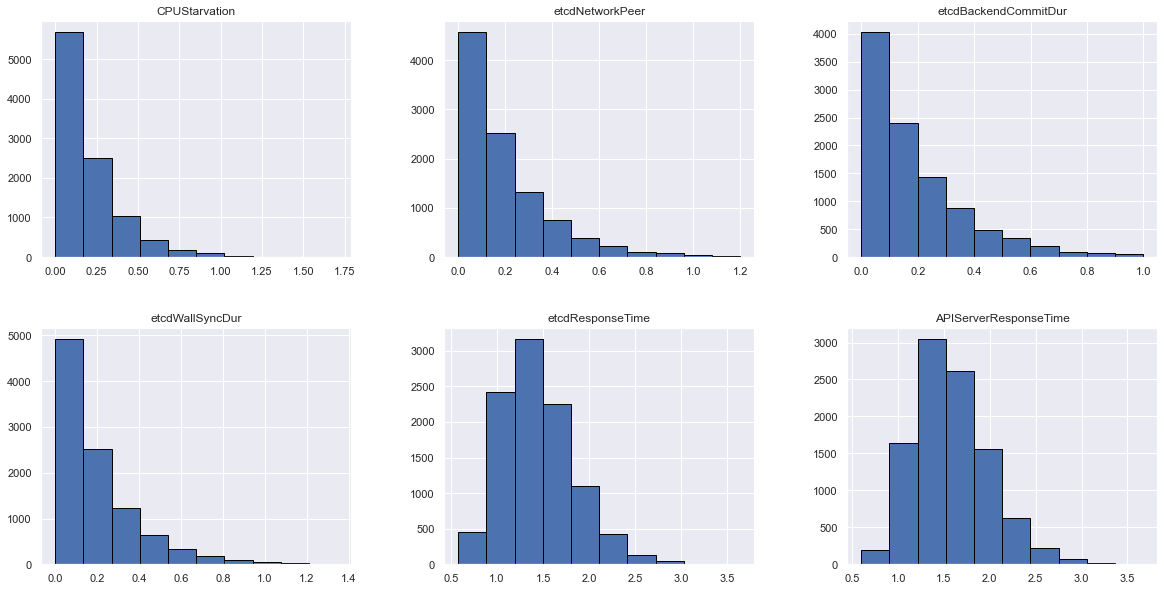

In [10]:
#need to debug what broke - examine_skewness_using_histogram(df,colnames) method
#define format for subplots (1 row and 3 columns)
fig, axis = plt.subplots(2, 3)

#create histogram for each column in DataFrame
#stable_df.hist(ax=axis)
stable_df.hist(ax=axis, edgecolor='black', grid=True)

Text(0.5, 1.0, 'etcdResponseTime')

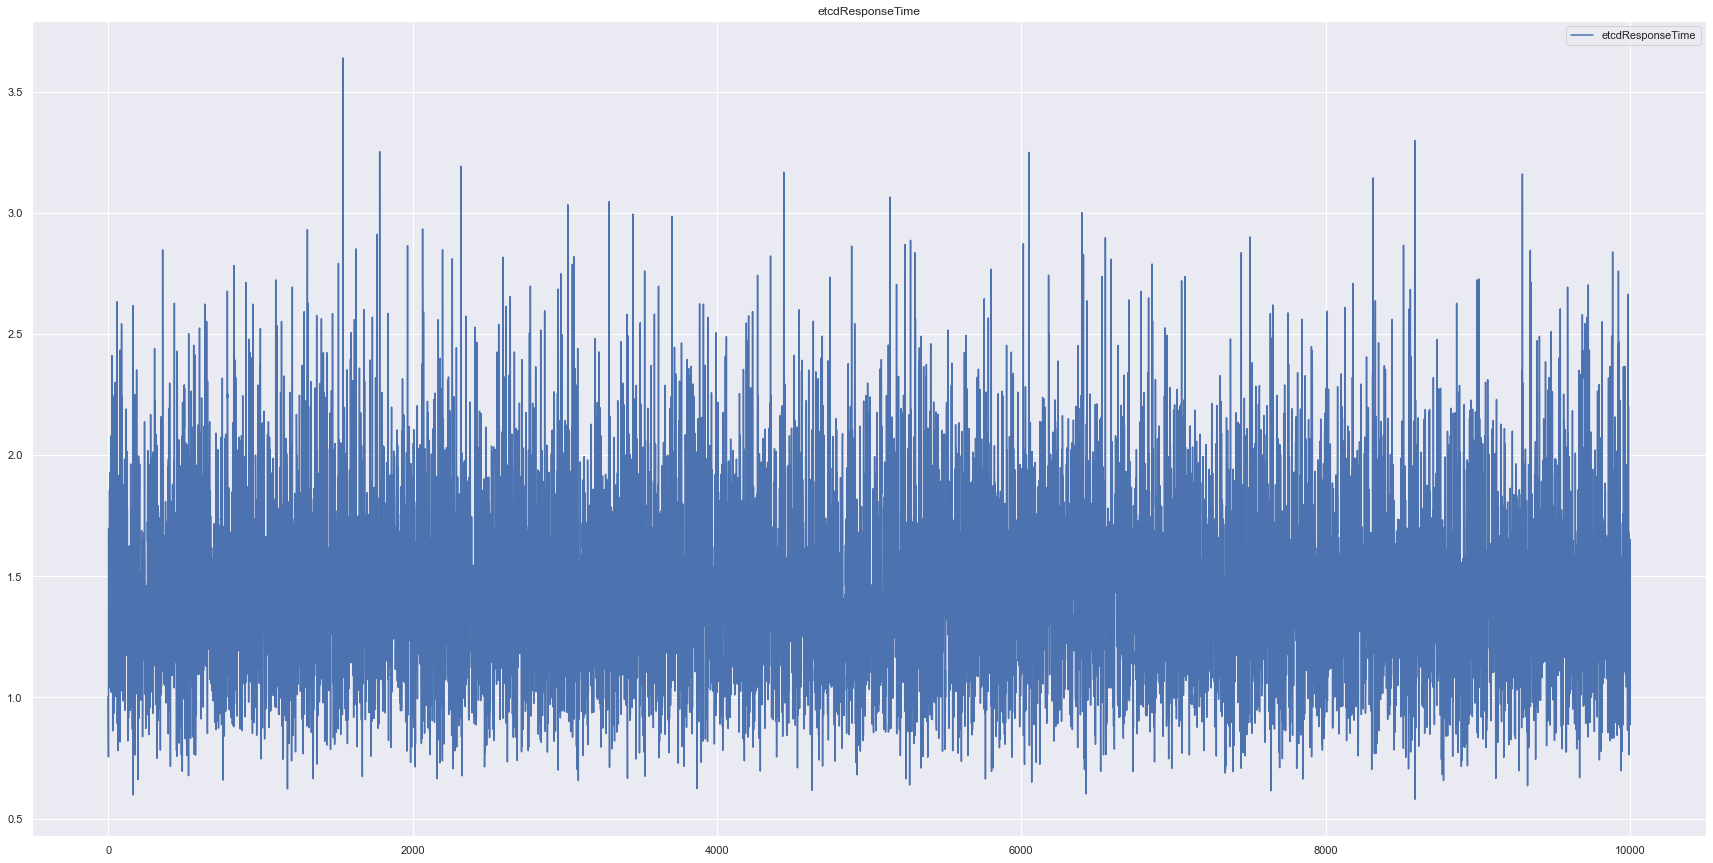

In [11]:
fig, ax = plt.subplots(figsize=(30,15)) 
stable_df.plot(y=["etcdResponseTime"], ax = ax)
plt.title("etcdResponseTime")

Text(0.5, 1.0, 'APIServerResponseTime')

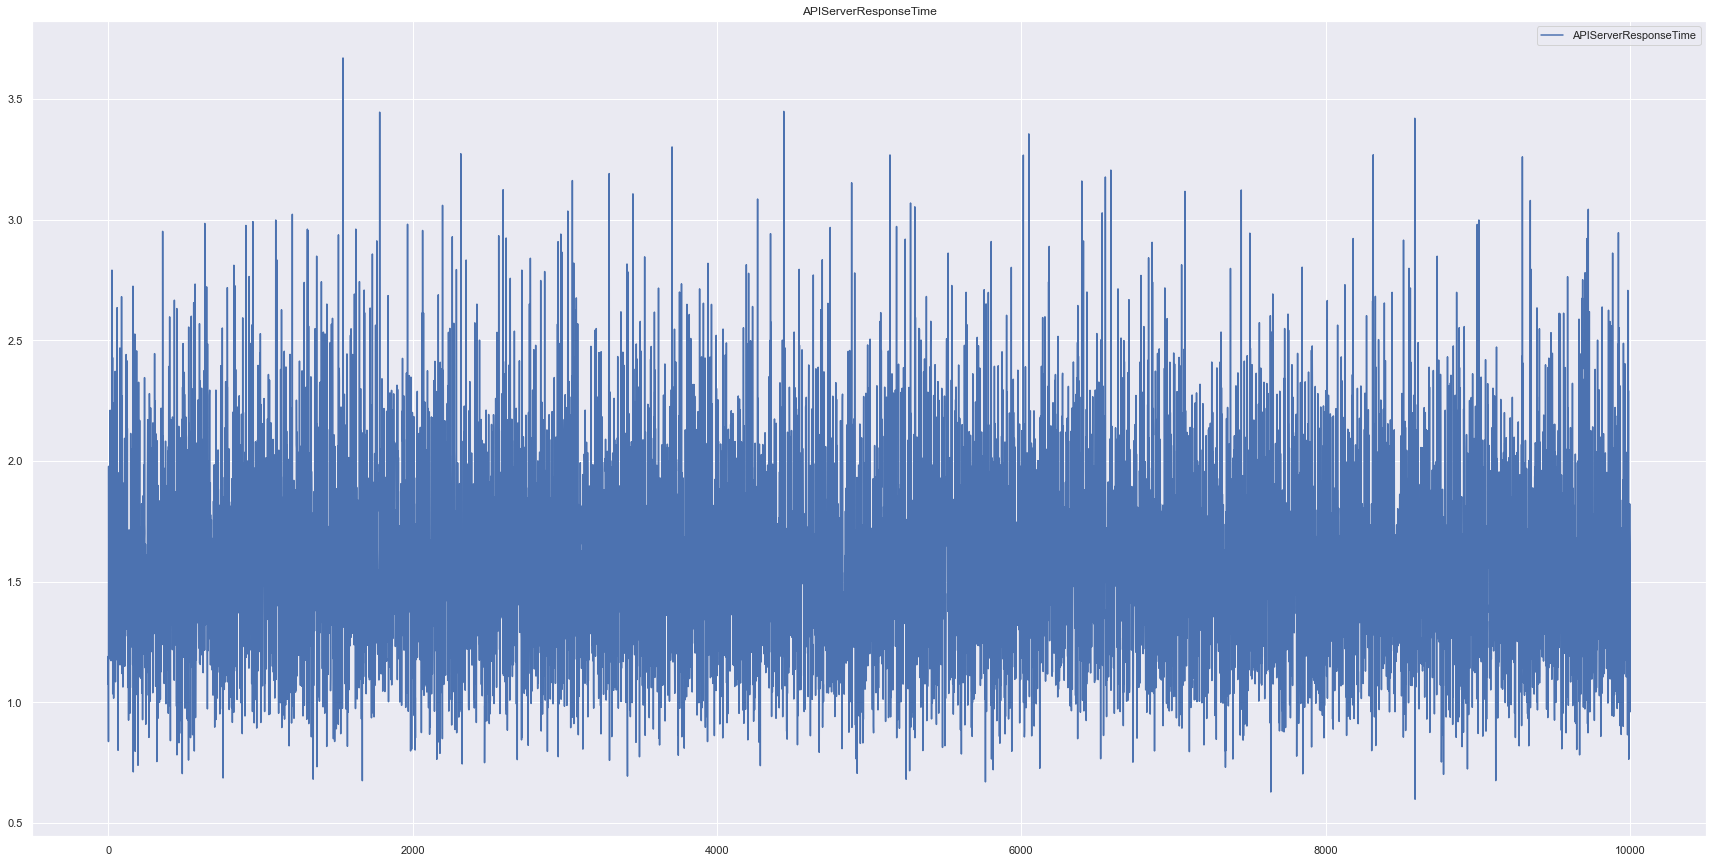

In [12]:
fig, ax = plt.subplots(figsize=(30,15)) 
stable_df.plot(y=["APIServerResponseTime"], ax = ax)
plt.title("APIServerResponseTime")

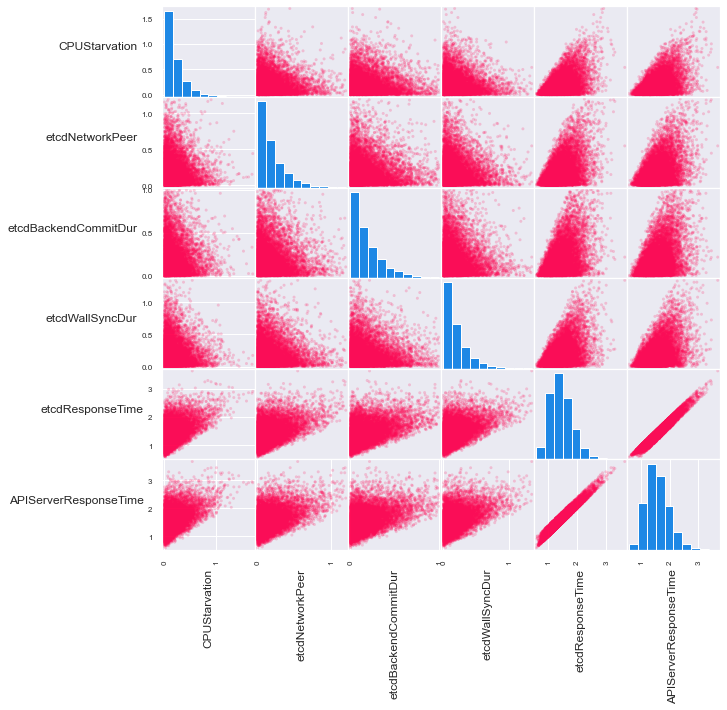

In [13]:
axes = pd.plotting.scatter_matrix(stable_df, figsize=(10, 10), c='#ff0d57', alpha=0.2, hist_kwds={'color':['#1E88E5']});
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

### Guide:
1. The first step is to model the cause-effect relationships between variables relevant to our use case. 
We did that in form of a causal graph earlier. A causal graph is a directed acyclic graph (DAG) where an edge X→Y implies that X causes Y. Statistically, a causal graph encodes the conditional independence relations between variables. 

2. To answer causal questions using causal graphs, we also have to know the nature of underlying data-generating process of variables. A causal graph by itself, being a diagram, does not have any information about the data-generating process. To introduce this data-generating process, we use an SCM (Structural Causal Model) that’s built on top of our causal graph.

3. Having created the causal model, we have capture the relationship between variables as captured by the underlying data-generating process.  Now we need to create the `Structural equations` for each of the nodes in the Causal DAG. Here, these mechanism can either be assigned manually if, for instance, prior knowledge about certain causal relationships are known or they can be assigned automatically using `auto.assign_causal_mechanisms` as we have done here

#### Structural Equations
We used `auto.assign_causal_mechanisms` and therefore by passed manually assigning the structural equations. What are they ?
1. When we say B := f(A) we mean `A` is a cause of `B`. Notice `:=` implies causation.
1. B := f(A) may sound like we are saying a value of `A` deterministically determines value of `B`. If this is not true, we can write is as B:=f(A, U) where `U` is variable which allows for any stochastic mapping between `A` to `B`.
1. Now, depending on the joint distribution of `A,B` this function could even by a regression model. We can assign themselves manually for each of the nodes in the Causal DAG if we happen to know it. (in this example, we chose `auto`)
1. Graphically this means `A` is direct parent of `B` and we are adding also an equation that captures how is B derived from A. `U` is usually not shown in the graphs and they are call exogeneous variables - they are modeled.

#### Structural Causal Model
Structural Causal model is a 
- Causal DAG
- and a set of Structural Equations that describes how to generate data for child node `B` from its direct parent `A` or more than 1 parent if dictated by the DAG


In [14]:
scm_model = gcm.StructuralCausalModel(causal_graph_used)

### Note
We could have tried to create the structural equations per node but skipped this since this is generated data. This is what we will do when we take in real data

In [15]:
gcm.auto.assign_causal_mechanisms(scm_model, stable_df)

In [16]:
stable_df.mean()

CPUStarvation            0.201281
etcdNetworkPeer          0.193991
etcdBackendCommitDur     0.190251
etcdWallSyncDur          0.198543
etcdResponseTime         1.445205
APIServerResponseTime    1.582895
dtype: float64

### Load the outlier Data

In [17]:
outlier_df=load_file("outlier_data.csv")

# Check the outlier means to see the deviations from stable mean
outlier_df.mean()

CPUStarvation            0.197322
etcdNetworkPeer          2.200578
etcdBackendCommitDur     0.193425
etcdWallSyncDur          0.196036
etcdResponseTime         3.448195
APIServerResponseTime    3.582988
dtype: float64

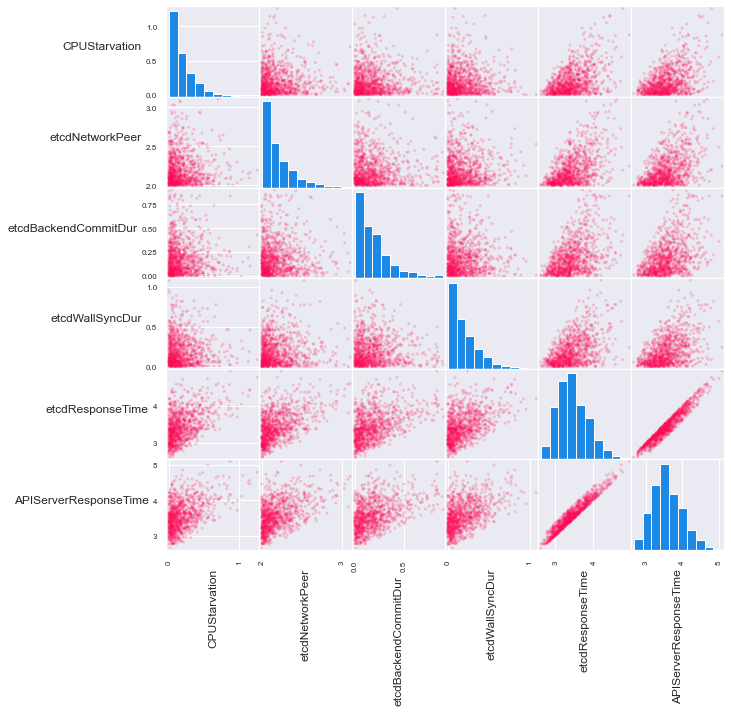

In [18]:
axes = pd.plotting.scatter_matrix(outlier_df, figsize=(10, 10), c='#ff0d57', alpha=0.2, hist_kwds={'color':['#1E88E5']});
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

### Run Attribution
- Find out the real issue in the batch of outlier data.
- Obviously the API Server Response Time is high and therefore the etcd Response Time is high.
- But why? Lets try to find this out.

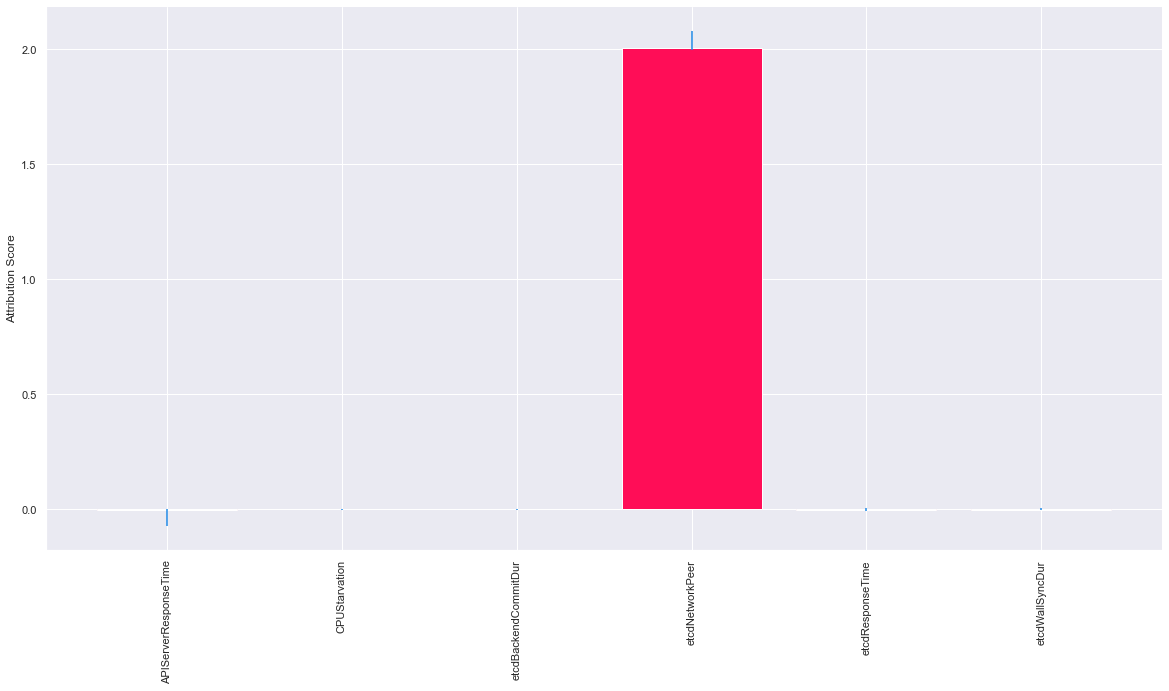

In [19]:
gcm.config.disable_progress_bars() # to disable print statements when computing Shapley values
median_attribs, uncertainty_attribs = gcm.confidence_intervals(
    lambda : gcm.distribution_change(scm_model,
                                     stable_df.sample(frac=0.6),
                                     outlier_df.sample(frac=0.6),
                                     'APIServerResponseTime',
                                     difference_estimation_func=lambda x, y: np.mean(y) - np.mean(x)),
    num_bootstrap_resamples = 10)

bar_plot(median_attribs, uncertainty_attribs, 'Attribution Score')

### So this assigned etcdNetworkPeer to be the main cause or more concretely : _changes in the etcdNetworkPeer to be main cause for this degradation_. This is absolutely correct.